In [1]:
import cv2 as cv
import mediapipe as mp
import pandas as pd
import sys
from collections import deque

In [2]:
sys.path.insert(0, '../')

In [3]:
mp_hands = mp.solutions.hands

hands = mp_hands.Hands(static_image_mode = True,
    max_num_hands = 2,
    min_detection_confidence = 0.7,
    min_tracking_confidence = 0.5
)

In [4]:
train_hands = pd.read_csv(filepath_or_buffer='_classes_train.csv',sep = ',')
test_hands = pd.read_csv(filepath_or_buffer='_classes_test.csv',sep = ',')
valid_hands = pd.read_csv(filepath_or_buffer='_classes_valid.csv',sep = ',')
train_hands = train_hands.reset_index()
test_hands = test_hands.reset_index()
valid_hands = valid_hands.reset_index()


In [5]:
from utils import landmark

def obtain_landmarks(folder,list_hands):
    df_result = pd.DataFrame()
    for index, row in list_hands.iterrows():
        image = cv.imread('./{}/{}'.format(folder,row['filename']))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True
        if results.multi_hand_landmarks is not None:
            for hand_landmarks,handness in zip(results.multi_hand_landmarks,
                                                results.multi_handedness):
                # Calcular Landmarks
                landmark_list = landmark.calc_landmark_list(image, hand_landmarks)
                #Convertir a cordenadas relativas / normalizada
                pre_processed_landmark_list = landmark.pre_process_landmark(
                    landmark_list)
                data_result =  list(row[2:]) + list(pre_processed_landmark_list)
                df_result = pd.concat([df_result, pd.DataFrame([data_result])], ignore_index=True)
               

    return df_result, pre_processed_landmark_list



In [6]:
training_df,pre_process_landmark_train = obtain_landmarks('train_data', train_hands)
test_df, pre_process_landmark_test = obtain_landmarks('test_data', test_hands)
valid_df, pre_process_landmark_valid = obtain_landmarks('valid_data', valid_hands)

In [7]:
def assign_names(df,list):
    column_names = (train_hands.columns[2:]).tolist()
    landmark_name = []
    for row,landmarks in enumerate(list):
        landmark_name.append('landmark_{}'.format(row))
    dataframe_columns = column_names + landmark_name
    df.columns = dataframe_columns

In [8]:
assign_names(training_df, pre_process_landmark_train)
assign_names(test_df, pre_process_landmark_test)
assign_names(valid_df, pre_process_landmark_valid)


In [9]:
training_df

,A,B,C,D,E,EYE1,EYE2,F,G1,G2,...,landmark_32,landmark_33,landmark_34,landmark_35,landmark_36,landmark_37,landmark_38,landmark_39,landmark_40,landmark_41
0,0,0,0,0,0,0,0,0,0,0,...,0.646259,-0.278912,0.163265,-0.265306,0.591837,-0.122449,0.795918,0.000000,0.897959,0.061224
1,0,0,0,0,0,0,0,0,0,0,...,0.043165,-0.352518,-0.111511,-0.312950,-0.043165,-0.381295,0.021583,-0.298561,0.050360,-0.219424
2,0,0,0,0,0,0,0,0,0,0,...,-0.009404,-0.291536,-0.137931,-0.373041,-0.141066,-0.482759,-0.103448,-0.382445,-0.081505,-0.304075
3,0,0,0,0,0,0,0,0,0,0,...,0.056410,-0.702564,-0.087179,-0.553846,-0.071795,-0.769231,-0.056410,-0.897436,-0.056410,-1.000000
4,0,0,0,1,0,0,0,0,0,0,...,0.240642,-0.513369,-0.005348,-0.411765,0.080214,-0.609626,0.181818,-0.582888,0.219251,-0.513369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,0,0,0,0,0,0,0,0,0,0,...,-0.276190,-0.371429,-0.409524,-0.771429,-0.619048,-0.847619,-0.723810,-0.876190,-0.771429,-0.933333
6072,0,0,0,0,0,0,0,0,0,0,...,0.003953,-0.288538,-0.122530,-0.339921,-0.114625,-0.454545,-0.071146,-0.343874,-0.047431,-0.260870
6073,0,0,0,0,0,0,0,0,0,0,...,-0.110236,-0.503937,0.157480,-0.535433,0.125984,-0.818898,0.070866,-0.929134,0.062992,-1.000000
6074,0,0,0,0,0,1,0,0,0,0,...,-0.270440,0.566038,0.088050,0.402516,-0.069182,0.710692,-0.150943,0.685535,-0.169811,0.610063


In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [19]:
NUM_CLASSES = 32
MODEL_PATH_SAVE = './HandClassifier/keypoint_classifier.hdf5'
TFLITE_PATH_SAVE = './HandClassifier/keypoint_classifier.tflite'

In [20]:
#Construcción del data entrenamiento X y Y
y_train = pd.DataFrame(training_df.iloc[:, :32])
X_train = pd.DataFrame(training_df.iloc[:, 32:])
y_test = pd.DataFrame(test_df.iloc[:, :32])
X_test = pd.DataFrame(test_df.iloc[:, 32:])
y_valid = pd.DataFrame(valid_df.iloc[:, :32])
X_valid = pd.DataFrame(valid_df.iloc[:, 32:])

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((42, )),
    tf.keras.layers.Dense(280, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 280)               12040     
                                                                 
 dropout_1 (Dropout)         (None, 280)               0         
                                                                 
 dense_4 (Dense)             (None, 140)               39340     
                                                                 
 dense_5 (Dense)             (None, 32)                4512      
                                                                 
Total params: 55,892
Trainable params: 55,892
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    MODEL_PATH_SAVE, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [25]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=tf.metrics.CategoricalAccuracy()
)

In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=70,
    batch_size=256,
    validation_data=(X_valid, y_valid),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/70
23/24 [===========================>..] - ETA: 0s - loss: 3.1487 - categorical_accuracy: 0.1562
Epoch 1: saving model to ./HandClassifier\keypoint_classifier.hdf5
24/24 [==============================] - 1s 23ms/step - loss: 3.1377 - categorical_accuracy: 0.1593 - val_loss: 2.7317 - val_categorical_accuracy: 0.2953
Epoch 2/70
13/24 [===============>..............] - ETA: 0s - loss: 2.5600 - categorical_accuracy: 0.3251
Epoch 2: saving model to ./HandClassifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 8ms/step - loss: 2.4063 - categorical_accuracy: 0.3817 - val_loss: 1.9916 - val_categorical_accuracy: 0.5523
Epoch 3/70
22/24 [==========================>...] - ETA: 0s - loss: 1.7388 - categorical_accuracy: 0.5804
Epoch 3: saving model to ./HandClassifier\keypoint_classifier.hdf5
24/24 [==============================] - 0s 10ms/step - loss: 1.7215 - categorical_accuracy: 0.5815 - val_loss: 1.3715 - val_categorical_accuracy: 0.6865
Epoch 4/70
20/24 [==

In [27]:
# Evaluación del modelo
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

7/7 [==============================] - 0s 2ms/step - loss: 0.0527 - categorical_accuracy: 0.9851


In [28]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

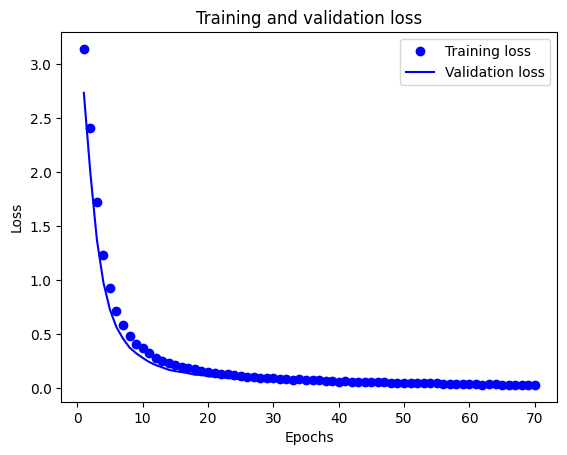

In [29]:

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


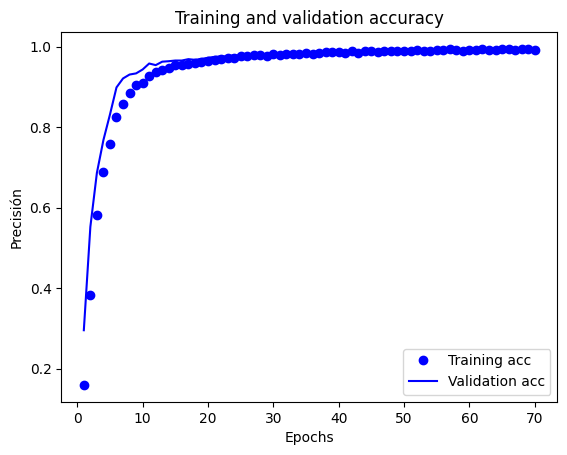

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend(loc='lower right')

plt.show()


In [31]:
# Loading the saved model
model = tf.keras.models.load_model(MODEL_PATH_SAVE)

In [32]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
    
    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)
    
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total
    
    class_report_df['avg / total'] = avg

    return class_report_df.T

28/28 [==============================] - 0s 1ms/step


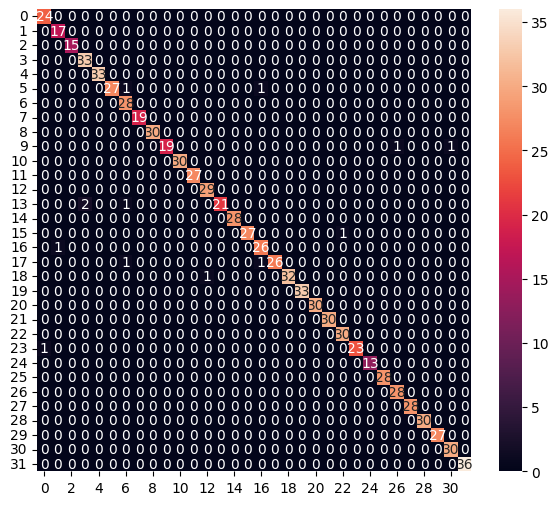

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       0.94      1.00      0.97        17
           2       1.00      1.00      1.00        15
           3       0.94      1.00      0.97        33
           4       1.00      1.00      1.00        33
           5       1.00      0.93      0.96        29
           6       0.90      1.00      0.95        28
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        30
           9       1.00      0.90      0.95        21
          10       1.00      1.00      1.00        30
          11       1.00      1.00      1.00        27
          12       0.97      1.00      0.98        29
          13       1.00      0.88      0.93        24
          14       1.00      1.00      1.00        28
          15       1.00      0.96      0.98        28
          16       0.93      0.96      0.95        27
     

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

y_test_true = np.array(y_test)
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test_true, axis=1)
print_confusion_matrix(y_true, y_pred)

In [34]:
# Guardar como modelo dedicado para interferencias
model.save(MODEL_PATH_SAVE, include_optimizer=False)

In [35]:
#Convertir a modelo TF-LITE

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(TFLITE_PATH_SAVE, 'wb').write(tflite_quantized_model)



INFO:tensorflow:Assets written to: C:\Users\katia\AppData\Local\Temp\tmp4oasl8u8\assets


INFO:tensorflow:Assets written to: C:\Users\katia\AppData\Local\Temp\tmp4oasl8u8\assets


59544

## Prueba de Interferencia

In [36]:
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH_SAVE)
interpreter.allocate_tensors()

In [37]:
# Obtener I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [38]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test.iloc[0]], dtype='float32'))

In [39]:
%%time
# Implementación de la interferencia
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 9.25 ms


In [40]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.4792913e-06 3.3234787e-04 2.3942478e-06 8.5284089e-04 9.7520169e-05
 7.3156725e-10 3.2980576e-12 1.3646357e-08 6.0554415e-09 9.6871838e-04
 6.3204852e-10 9.9044654e-04 3.7208042e-07 1.3522867e-08 2.0334715e-12
 7.6473434e-08 6.0801405e-05 2.8112157e-10 2.3375028e-06 1.0023118e-08
 2.0167214e-05 5.6201138e-08 2.7091894e-05 2.9207459e-07 7.1653474e-08
 9.9656075e-01 1.0326637e-16 3.7240250e-12 1.9425250e-09 1.1957726e-11
 7.9584979e-09 7.8293713e-05]
25
